This notebook will calculate the edge of a signal for very low statistics data

It is recommended that you narrow down the number of files to work on using ImageJ

[![Notebook Tutorial](../__code/__all/notebook_tutorial.png)](https://neutronimaging.pages.ornl.gov/en/tutorial/)

<img src='../__docs/__all/notebook_rules.png' />

In [1]:
import glob
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
% matplotlib notebook

import numpy as np
from scipy.ndimage import convolve

from ipywidgets import interact, widgets

import ipywe.fileselector

from NeuNorm.normalization import Normalization

import sys
sys.path.insert(0, os.path.abspath('..'))
from __code import system

system.System.select_working_dir()

** Using Debugging Mode! **


VBox(children=(HBox(children=(Label(value='IPTS-'), Text(value='', layout=Layout(width='10%')), Label(value='DOES NOT EXIST!', layout=Layout(width='20%'), _dom_classes=('result_label',)))), Label(value='OR'), HBox(children=(Label(value='Select Folder', layout=Layout(width='20%')), Select(layout=Layout(height='300px'), options=('BraggEdge', 'Brianne', 'DOE_letters', 'FITSimages', 'IPTS-12534', 'IPTS-13639_resonance_shawn', 'IPTS-14832', 'IPTS-15177', 'IPTS-16212', 'IPTS-16259', 'IPTS-16475', 'IPTS-16893', 'IPTS-17099', 'IPTS-17685-Siddharth', 'IPTS-17981', 'IPTS-18580', 'IPTS-18806', 'IPTS-18813', 'IPTS-19037', 'IPTS-19213', 'IPTS-19558', 'IPTS-19621', 'IPTS-19626', 'IPTS-19799', 'IPTS-19921-Charles', 'IPTS-20209-TOPAZ', 'IPTS-Das-Saikat', 'IPTS_test_normalization', 'IPTS_testing_time_spectra', 'ImagesToRegisterForGian', 'Indu', 'Keita_code', 'Pour_ibeatles_video', 'ResonanceImaging', 'SENSITIVE', 'SarmaGUI', 'SphereCoordinates3D', 'TempData', 'gian', 'iBeatles_debugging', 'shared', 'testing_Ed_algo_water_intake'), value='BraggEdge'))), Button(button_style='info', description='HELP', style=ButtonStyle())))

# Define input data files 

## User input here 

In [2]:
list_files_ui = ipywe.fileselector.FileSelectorPanel(instruction='Select Images...',
                                                      multiple=True,
                                                      start_dir = system.System.get_working_dir())
list_files_ui.show()

VBox(children=(Label(value='Select Images...', layout=Layout(width='250px')), VBox(children=(HBox(children=(HBox(children=(Text(value='/Volumes/my_book_thunderbolt_duo/IPTS/IPTS-Das-Saikat', description='Location: ', layout=Layout(width='100%'), placeholder=''), Button(description='Jump', layout=Layout(border='1px solid gray', margin='5px 10px', width='100px'), style=ButtonStyle())), layout=Layout(border='1px solid lightgrey', margin='5px 50px 5px 5px', padding='3px', width='100%')),)), HBox(children=(VBox(children=(HBox(children=(Label(value='Search:'), Text(value='', layout=Layout(width='50%'))), layout=Layout(justify_content='flex-end')), SelectMultiple(description='Select', layout=Layout(height='260px', width='99%'), options=(' .', ' ..', ' .DS_Store                 |     Mon Apr 16 16:35:54 2018', ' only_data_of_interest     |     Directory', ' renamed_water200          |     Directory'), value=())), layout=Layout(width='80%')), VBox(children=(Button(description='Change directory', layout=Layout(border='1px solid gray', margin='5px 40px'), style=ButtonStyle()), Button(description='Select', layout=Layout(border='1px solid blue', margin='auto 40px 5px'), style=ButtonStyle())))), layout=Layout(border='1px solid lightgrey', margin='5px', padding='10px')))), HTML(value='')))

# Loading and preview of the data 

In [3]:
list_files = list_files_ui.selected

o_norm = Normalization()
o_norm.load(file=list_files, notebook=True)
data = o_norm.data['sample']['data']

def plot(index):
    fig, ax = plt.subplots(figsize=(5,5))
    cax = ax.imshow(data[index], cmap='viridis')
    fig.colorbar(cax)
interact(plot,
        index=widgets.IntSlider(min=0,
                         max=len(data)-1,
                         value=0,
                         continuous_update=False
                           ))

HBox(children=(Label(value='Loading sample', layout=Layout(width='20%')), IntProgress(value=0, max=10), Label(value='Time remaining:', layout=Layout(width='10%')), Label(value=' >> calculating << ')))

interactive(children=(IntSlider(value=0, continuous_update=False, description='index', max=9), Output()), _dom_classes=('widget-interact',))

<function __main__.plot>

# Crop 

## User input here 

In [4]:
x0_crop = 0
x1_crop = 460
y0_crop = 232
y1_crop = 285

# Cropping the data 

In [5]:
crop_data = [_data[y0_crop:y1_crop, x0_crop:x1_crop] for _data in data]

def plot(index):
    fig, ax = plt.subplots(figsize=(12,2))
    cax = ax.imshow(crop_data[index], cmap='viridis')
    fig.colorbar(cax)
interact(plot,
        index=widgets.IntSlider(min=0,
                         max=len(data)-1,
                         value=0,
                         continuous_update=False
                           ))

interactive(children=(IntSlider(value=0, continuous_update=False, description='index', max=9), Output()), _dom_classes=('widget-interact',))

<function __main__.plot>

# Trying to reverse signal

Will take the max intensity and reverse all the values

```
new_pixel = max_value_of_image - old_pixel
```

In [6]:
max_values = [np.max(_data) for _data in crop_data]
crop_data_reversed = [(_max_value - _data) for (_data, _max_value) in zip(crop_data, max_values)]

def plot(index):
    fig, ax = plt.subplots(figsize=(12,2))
    cax = ax.imshow(crop_data_reversed[index], cmap='viridis')
    fig.colorbar(cax)
interact(plot,
        index=widgets.IntSlider(min=0,
                         max=len(data)-1,
                         value=0,
                         continuous_update=False
                           ))

interactive(children=(IntSlider(value=0, continuous_update=False, description='index', max=9), Output()), _dom_classes=('widget-interact',))

<function __main__.plot>

# Basic histogram segmentation 

## User input here 

In [7]:
# define threshold value
threshold = np.array(max_values) - 1  # we remove all the pixels that are below the max value

## segmentation 

In [8]:
segmented_data = []
for _index, _data in enumerate(crop_data_reversed):
    _index = _data <= threshold[_index]
    _data[_index] = np.NaN
    segmented_data.append(_data)
    
def plot(index):
    fig, ax = plt.subplots(figsize=(12,2))
    cax = ax.imshow(segmented_data[index], cmap='viridis')
    fig.colorbar(cax)
interact(plot,
        index=widgets.IntSlider(min=0,
                         max=len(data)-1,
                         value=0,
                         continuous_update=False
                           ))

interactive(children=(IntSlider(value=0, continuous_update=False, description='index', max=9), Output()), _dom_classes=('widget-interact',))

<function __main__.plot>

# Profile along x-axis 

In [9]:
profiles_x_axis = np.nansum(segmented_data, axis=1)
def plot(index):
    fig, ax = plt.subplots(figsize=(5,5))
    cax = ax.plot(profiles_x_axis[index])
    
interact(plot,
        index=widgets.IntSlider(min=0,
                         max=len(data)-1,
                         value=0,
                         continuous_update=False
                           ))

interactive(children=(IntSlider(value=0, continuous_update=False, description='index', max=9), Output()), _dom_classes=('widget-interact',))

<function __main__.plot>

NB: This clearly show that we can not use that profile to calculate the water intake pixel position

# profile along user defined line 

* User defines start and end of line (using #6.2)
* algorithm will then keep the pixel within a given width (number of pixels) of this line
* profile along the line is display



## User input here


right and left point position for the linear profile

In [10]:
x0, y0 = 450, 20
x1, y1 = 104, 26

## extract data 

In [11]:
%matplotlib inline

In [12]:
def _intermediates_points(p1, p2):
    """"Return a list of nb_points equally spaced points
    between p1 and p2

    p1 = [x0, y0]
    p2 = [x1, y1]
    """

    # nb_points ?
    nb_points = np.int(3 * max([np.abs(p1[0] - p2[0]), np.abs(p2[1] - p1[1])]))

    x_spacing = (p2[0] - p1[0]) / (nb_points + 1)
    y_spacing = (p2[1] - p1[1]) / (nb_points + 1)

    full_array = [[np.int(p1[0] + i * x_spacing), np.int(p1[1] + i * y_spacing)]
                  for i in range(1, nb_points + 1)]

    clean_array = []
    for _points in full_array:
        if _points in clean_array:
            continue
        clean_array.append(_points)

    return np.array(clean_array)

full_line = _intermediates_points([x0,y0], [x1,y1])[::-1]
x_axis_line = full_line[:,0]

all_profiles_along_line = []
width = 1 # 2 pixels on each side
for _segmented_data in segmented_data:
    _data = []
    for _x_y in full_line:
        _x, _y = _x_y
        _data.append(np.nanmean(_segmented_data[_y-width:_y+width+1, _x]))
    all_profiles_along_line.append(_data)

def plot(index):
    fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(20,20))
    cax = ax[0].imshow(segmented_data[index], cmap='viridis')
    cax = ax[1].imshow(segmented_data[index], cmap='viridis')
    for _x_y in full_line:
        _x = _x_y[0]
        _y = _x_y[1]
        ax[1].scatter([_x], [_y])
    
    _xaxis = np.arange(len(all_profiles_along_line[index])) + x1
    ax[2].plot(_xaxis, all_profiles_along_line[index])
    
    
interact(plot,
        index=widgets.IntSlider(min=0,
                         max=len(data)-1,
                         value=0,
                         continuous_update=False
                           ))

/Users/j35/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice


interactive(children=(IntSlider(value=0, continuous_update=False, description='index', max=9), Output()), _dom_classes=('widget-interact',))

<function __main__.plot>

I'm now plotting the length of the line the pixel corresponds to verus pixel poition

In [13]:
def calculate_length_of_each_segment(profile=[]):

    # replace nan values by -2
    nan_substitute = -2
    profile = np.array(profile)
    profile_index = [np.isnan(profile)]
    profile[profile_index] = nan_substitute
    
    x0 = 0
    current_value = -1
    
    dict_segment = {}
    
    line_number = 0
    start_flag = True
    start_point = True
    end_point = False
    _dict = {}
    
    for _index in np.arange(len(profile)):
        _live_value = profile[_index]
#         print("live_value: {} at index: {}".format(_live_value, _index))
        # not nan value
        # we reached an edge of a segment
        if _live_value != current_value:
#             print("live_value is different than current_value (start_point, end_point):({},{})".format(start_point, end_point))

            current_value = _live_value
            
            if start_flag:
#                 print("-> starting a new line")
                _dict={}
                _dict['start'] = _index
                if current_value == nan_substitute:
                    _dict['value'] = np.NaN
                else:
                    _dict['value'] = current_value
                start_flag = not start_flag
            else:
#                 print("-> finishing a line")
                _dict['end'] = _index-1           
                _dict['length'] = _dict['end'] - _dict['start']
                dict_segment[str(line_number)] = _dict
                line_number += 1
                
#                 print("-> and starting a new one")
                _dict={}
                _dict['start'] = _index
                if current_value == nan_substitute:
                
                    _dict['value'] = np.NaN
                else:
                    _dict['value'] = current_value
                
        current_value = _live_value
        
    _dict['end'] = _index
    _dict['length'] = _dict['end'] - _dict['start']
    dict_segment[str(line_number)] = _dict
        
    return dict_segment

full_dict_array = []
for _profile in all_profiles_along_line:
    full_dict_array.append(calculate_length_of_each_segment(profile=_profile))

def isolate_length_vs_x(dict_array):
    nbr_point = len(dict_array)
    x_axis = []
    y_axis = []
    for _key in dict_array.keys():
        _entry = dict_array[_key]
#         if not np.isnan(_entry['value']):
#             x_axis.append(x1+ np.mean([_entry['start'], _entry['end']]))
        _start = _entry['start']
        _end = _entry['end']
        for _x in np.arange(_start, _end+1):
            x_axis.append(_x + x1)
            y_axis.append(_entry['length'])
    
    return (x_axis, y_axis)

length_vs_x = {}
for index, dict_array in enumerate(full_dict_array):
    [x_axis, y_axis] =isolate_length_vs_x(dict_array)
    length_vs_x[str(index)] = {'x_axis': x_axis,
                               'y_axis': y_axis}

# display the length of each
def plot(index):

    fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(10,10))
    
    # preview of crop image
    cax = ax[0].imshow(segmented_data[index], cmap='viridis')

    # display of length of lines
    _xaxis = np.arange(len(all_profiles_along_line[index])) + x1
    ax[1].plot(_xaxis, all_profiles_along_line[index])
    ax[1].set_title("lines of continued max value")
    ax[1].set_ylabel("Counts")
    
 # length of lines vs pixel
    x_axis = length_vs_x[str(index)]['x_axis']
    y_axis = length_vs_x[str(index)]['y_axis']
    ax[2].plot(x_axis, y_axis, '*r')
    ax[2].set_title("length of corresponding lines for each pixel")
    ax[2].set_ylabel("Length of correspoonding line")
    ax[2].set_xlabel("Pixel")
    
interact(plot,
        index=widgets.IntSlider(min=0,
                         max=len(data)-1,
                         value=0,
                         continuous_update=False
                           ))

interactive(children=(IntSlider(value=0, continuous_update=False, description='index', max=9), Output()), _dom_classes=('widget-interact',))

<function __main__.plot>

# Calculate front of signal

In [14]:
class MeanRangeCalculation():
    '''
    Mean value of all the counts between left_pixel and right pixel
    '''

    def __init__(self, data=None):
        self.data = data
        self.nbr_pixel = len(self.data)

    def calculate_left_right_mean(self, pixel=-1):
        _data = self.data
        _nbr_pixel = self.nbr_pixel

        self.left_mean = np.nanmean(_data[0:pixel+1])
        self.right_mean = np.nanmean(_data[pixel+1:_nbr_pixel])

    def calculate_delta_mean_square(self):
        self.delta_square = np.square(self.left_mean - self.right_mean)

peak_position = []
end_pixel_cutoff = 1
full_delta_array = []
for _key in length_vs_x.keys():
    
    x_axis = length_vs_x[_key]['x_axis']
    y_axis = length_vs_x[_key]['y_axis']
    
    o_range = MeanRangeCalculation(data = y_axis)
    nbr_pixels = len(x_axis)
    delta_array = []
    for _pixel in np.arange(0, nbr_pixels-end_pixel_cutoff):
        o_range.calculate_left_right_mean(pixel=_pixel)
        o_range.calculate_delta_mean_square()
        delta_array.append(o_range.delta_square)
        
    peak_value = delta_array.index(max(delta_array[0: nbr_pixels-end_pixel_cutoff]))
    peak_position.append(peak_value+np.min([x0, x1]))
    full_delta_array.append(delta_array)

def plot(index):
    fig, ax = plt.subplots()
    ax.plot(x_axis[0: nbr_pixels-end_pixel_cutoff], full_delta_array[index], label='delta_array')
    y_axis = length_vs_x[str(index)]['y_axis']
    second_x_axis = np.arange(np.min([x0, x1]), np.min([x0, x1]) + len(y_axis))
    ax.plot(second_x_axis, y_axis, 'r', label='length of lines')
    ax.legend()
    
interact(plot,
        index=widgets.IntSlider(min=0,
                         max=len(data)-1,
                         value=0,
                         continuous_update=False
                           ))

interactive(children=(IntSlider(value=0, continuous_update=False, description='index', max=9), Output()), _dom_classes=('widget-interact',))

<function __main__.plot>

In [15]:
# display the length of each
[height, width] = np.shape(segmented_data[0])

def plot(index):

    fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(10,10))
    
    # preview of crop image
    cax = ax[0].imshow(segmented_data[index], cmap='viridis')
    print(peak_position[index])
    _peak = patches.Rectangle((peak_position[index], 0),
                             1,
                             height,
                             edgecolor = 'red',
                             linewidth=2,
                             fill=False)
    ax[0].add_patch(_peak)
    
    # display of length of lines
    _xaxis = np.arange(len(all_profiles_along_line[index]))+ np.min([x0, x1])
    ax[1].plot(_xaxis, all_profiles_along_line[index])
    ax[1].set_title("lines of continued max value")
    ax[1].set_ylabel("Counts")
    ax[1].axvline(peak_position[index], c='red')
 # length of lines vs pixel
    x_axis = length_vs_x[str(index)]['x_axis']
    y_axis = length_vs_x[str(index)]['y_axis']
    ax[2].plot(x_axis, y_axis, '*r')
    ax[2].set_title("length of corresponding lines for each pixel")
    ax[2].set_ylabel("Length of correspoonding line")
    ax[2].set_xlabel("Pixel")
    ax[2].axvline(peak_position[index], c='blue')
    
interact(plot,
        index=widgets.IntSlider(min=0,
                         max=len(data)-1,
                         value=0,
                         continuous_update=False
                           ))

interactive(children=(IntSlider(value=0, continuous_update=False, description='index', max=9), Output()), _dom_classes=('widget-interact',))

<function __main__.plot>

# Display evolution of peak signal 

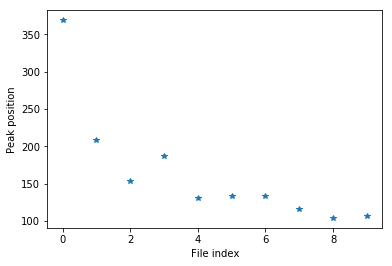

In [16]:
fig, ax = plt.subplots()
ax.plot(peak_position, '*')
ax.set_ylabel("Peak position")
ax.set_xlabel("File index")